In [170]:
import rasterio 
import rasterio.rio
import rasterio.plot
import pyproj
import numpy as np
import boto3 as bt
import matplotlib
import matplotlib.pyplot as plt

# Open a tiff file

In [171]:
print('UAF-alt.tif:')
filepath1 = r'C:\Users\emack\Documents\UAF-Temperature\data\alt.tif'
with rasterio.open(filepath) as d_alt:
    print(d_alt.profile)

UAF-alt.tif:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 43201, 'height': 15156, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.00833333376795053, 0.0, -180.0,
       0.0, -0.00833333376795053, 71.53334019333124), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [172]:
print('UAF-amphibians.tif:')
filepath2 = r'C:\Users\emack\Documents\UAF-Temperature\data/amphibians.tif'
with rasterio.open(filepath) as d_amphib:
    print(d_amphib.profile)

UAF-amphibians.tif:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 43201, 'height': 15156, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.00833333376795053, 0.0, -180.0,
       0.0, -0.00833333376795053, 71.53334019333124), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


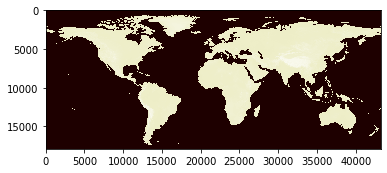

In [173]:
sr1 = rasterio.open(r'C:\Users\emack\Documents\UAF-Temperature\data/amphibians.tif')
plt.imshow(sr1.read(1), cmap='pink')

sr2 = rasterio.open(r'C:\Users\emack\Documents\UAF-Temperature\data/alt.tif')
plt.imshow(sr2.read(1), cmap='pink')

plt.show()

# Get the band count

In [174]:
print(d_alt.count)
print(d_amphib.count)

1
1


###  Get the dimensions of the band arrays

In [175]:
print('Band width is ',d_alt.width)
print('Band height is ',d_alt.height)

Band width is  43201
Band height is  15156


### Get the mapping of band indexes to variable type

In [176]:
{i: dtype for i, dtype in zip(d_alt.indexes, d_alt.dtypes)}

{1: 'uint8'}

# Dataset georeferencing
Get the bounds of our dataset

In [177]:
d_alt.bounds

BoundingBox(left=-180.0, bottom=-54.76666639372698, right=180.00835210923083, top=71.53334019333124)

### A dataset’s transform is an affine transformation matrix that maps pixel locations in (row, col) coordinates to (x, y) spatial positions. The product of this matrix and (0, 0), the row and column coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner.

In [178]:
d_alt.transform

Affine(0.00833333376795053, 0.0, -180.0,
       0.0, -0.00833333376795053, 71.53334019333124)

### Get the position of the lower right corner

In [179]:
d_alt.transform * (0, 0)

(-180.0, 71.53334019333124)

# Get the coordinate reference system (CRS)

In [180]:
d_alt.crs

CRS.from_dict(init='epsg:4326')

# Spatial indexing

Datasets have an index() method for getting the array indices corresponding to points in georeferenced space. To get the value for the pixel 100 kilometers east and 50 kilometers south of the dataset’s upper left corner, do the following.

In [183]:
d_alt.indexes
#band1 = d_alt.read(1)

(1,)

In [184]:
band1

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

### To get the spatial coordinates of a pixel, use the dataset’s xy() method. The coordinates of the center of the image can be computed like this.

In [185]:
band1[dataset.height // 2, dataset.width // 2]

291

In [186]:
x, y = (d_alt.bounds.left -180, d_alt.bounds.top + 89)
row, col = d_alt.index(x, y)
row, col

band1[row, col]


178